In [1]:
!pip install -q -U autogluon.tabular ray

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.0 requires aiohttp<4.0.0,>=3.9.2, which is not installed.
s3fs 2024.3.1 requires aiohttp!=4.0.0a0,!=4.0.0a1, which is not installed.
aiobotocore 2.13.0 requires botocore<1.34.107,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


# Imports and Configs

In [2]:
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import pickle
import glob

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

In [3]:
TIME_LIMIT = 3600 * 10
N_FOLDS = 5
SEED = 27
TARGET = 'Target'

# Loading the Datasets

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [5]:
train = TabularDataset(train)
test = TabularDataset(test)

# Training

In [6]:
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

histories = {}
oof_preds = np.zeros((len(train), train[TARGET].nunique()))
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train.drop(columns=TARGET), train[TARGET])):
    _train, _val = train.iloc[train_idx], train.iloc[val_idx]    

    predictor = TabularPredictor(
        label=TARGET,
        eval_metric='accuracy',
        problem_type='multiclass',
        verbosity=2
    ).fit(
        train_data=_train,
        time_limit=TIME_LIMIT // N_FOLDS,
        presets='best_quality',
        save_space=True,
#         hyperparameter_tune_kwargs={  
#             'num_trials': 25,
#             'scheduler' : 'local',
#             'searcher'  : 'auto'
#         },
#         feature_prune_kwargs={'force_prune': True}
    )
    
    fold_score = predictor.evaluate(_val, silent=True)['accuracy']
    
    pred_probs = predictor.predict_proba(_val)
    preds = pred_probs.idxmax(axis=1).values
    oof_preds[val_idx] = pred_probs
    
    test_pred_probs = predictor.predict_proba(test)
    
    test_preds = test_pred_probs.idxmax(axis=1).values
    test_preds = pd.DataFrame({TARGET: test_preds}, index=test.index)
    test_preds.to_csv(f'fold_{fold_idx}_test_preds_acc-{fold_score:.6f}.csv')
    
    test_pred_probs = pd.DataFrame(test_pred_probs, index=test.index)
    test_pred_probs.to_csv(f'fold_{fold_idx}_test_pred_probs_acc-{fold_score:.6f}.csv')
    
    histories[f'Fold {fold_idx}'] = {}
    histories[f'Fold {fold_idx}']['summary'] = predictor.fit_summary()
    histories[f'Fold {fold_idx}']['leaderboard'] = predictor.leaderboard(_val, silent=True)
    histories[f'Fold {fold_idx}']['feature_importance'] = predictor.feature_importance(_val, silent=True)
    histories[f'Fold {fold_idx}']['y'] = _val[TARGET].values
    histories[f'Fold {fold_idx}']['pred_probs'] = pred_probs
    histories[f'Fold {fold_idx}']['preds'] = preds
    histories[f'Fold {fold_idx}']['accuracy'] = fold_score
    histories[f'Fold {fold_idx}']['auc'] = roc_auc_score(_val[TARGET], pred_probs, multi_class='ovo')
    
    
    print(f'Fold {fold_idx} - Accuracy: {fold_score}')
    
    shutil.rmtree("AutogluonModels")
    del predictor

No path specified. Models will be saved in: "AutogluonModels/ag-20240603_181803"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240603_181803/ds_sub_fit/sub_fit_ho.
2024-06-03 18:18:04,307	INFO util.py:124 -- Outdated packages:
  ipywidgets==7

[1000]	valid_set's multi_error: 0.173063


	0.8297	 = Validation score   (accuracy)
	91.87s	 = Training   runtime
	2.85s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 605.31s of the 1205.43s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8317	 = Validation score   (accuracy)
	50.39s	 = Training   runtime
	1.22s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 553.19s of the 1153.31s of remaining time.
	0.824	 = Validation score   (accuracy)
	15.6s	 = Training   runtime
	3.35s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 533.19s of the 1133.31s of remaining time.
	0.8242	 = Validation score   (accuracy)
	16.27s	 = Training   runtime
	3.35s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 512.58s of the 1112.7s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3   0.833551    accuracy      53.530806  4844.571487                0.010083           5.727493            3       True         31
1        NeuralNetFastAI_BAG_L2   0.832914    accuracy      46.401949  4126.806999                1.302026         613.808566            2       True         20
2                XGBoost_BAG_L2   0.832424    accuracy      45.656244  3573.310880                0.556321          60.312447            2       True         28
3           WeightedEnsemble_L2   0.832375    accuracy       5.695600   224.291331                0.009215           3.691729            2       True         19
4               LightGBM_BAG_L2   0.832359    accuracy      45.430105  3598.304058                0.330182          85.305625        

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Plot summary of models saved to file: AutogluonModels/ag-20240603_181803SummaryOfModels.html
*** End of fit() summary ***


INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on

Fold 0 - Accuracy: 0.8340956612650288


No path specified. Models will be saved in: "AutogluonModels/ag-20240603_210636"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240603_210636/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

[1000]	valid_set's multi_error: 0.17172


	0.831	 = Validation score   (accuracy)
	136.42s	 = Training   runtime
	4.28s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4638.97s of the 4638.95s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8303	 = Validation score   (accuracy)
	75.79s	 = Training   runtime
	1.91s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 4560.53s of the 4560.51s of remaining time.
	0.8244	 = Validation score   (accuracy)
	18.65s	 = Training   runtime
	4.03s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 4537.03s of the 4537.01s of remaining time.
	0.8242	 = Validation score   (accuracy)
	19.43s	 = Training   runtime
	3.89s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 4512.94s of the 4512.92s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingS

[1000]	valid_set's multi_error: 0.172112
[1000]	valid_set's multi_error: 0.177078
[2000]	valid_set's multi_error: 0.173157
[3000]	valid_set's multi_error: 0.173419
[1000]	valid_set's multi_error: 0.177339
[2000]	valid_set's multi_error: 0.174726
[3000]	valid_set's multi_error: 0.174203
[1000]	valid_set's multi_error: 0.169237
[2000]	valid_set's multi_error: 0.165839
[1000]	valid_set's multi_error: 0.171197
[1000]	valid_set's multi_error: 0.17501
[2000]	valid_set's multi_error: 0.172265
[1000]	valid_set's multi_error: 0.174095
[2000]	valid_set's multi_error: 0.169651
[3000]	valid_set's multi_error: 0.169128


	0.8299	 = Validation score   (accuracy)
	430.83s	 = Training   runtime
	14.73s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 235.87s of the 235.85s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 9)
	Ran out of time, stopping training early. (Stopping on epoch 10)
	Ran out of time, stopping training early. (Stopping on epoch 10)
	Ran out of time, stopping training early. (Stopping on epoch 11)
	Ran out of time, stopping training early. (Stopping on epoch 11)
	Ran out of time, stopping training early. (Stopping on epoch 13)
	Ran out of time, stopping training early. (Stopping on epoch 16)
	0.8215	 = Validation score   (accuracy)
	223.69s	 = Training   runtime
	0.84s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 11.18s of the 11.16s of remaining time.
	Fitting 8 child models (S1F1 - S

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0                XGBoost_BAG_L1   0.831346    accuracy       1.073603    54.965463                1.073603          54.965463            1       True         11
1           WeightedEnsemble_L2   0.831346    accuracy       1.081865    59.261229                0.008262           4.295766            2       True         22
2             LightGBMXT_BAG_L1   0.830954    accuracy       4.283566   136.421147                4.283566         136.421147            1       True          4
3               LightGBM_BAG_L1   0.830333    accuracy       1.912156    75.791539                1.912156          75.791539            1       True          5
4            CatBoost_r9_BAG_L1   0.829974    accuracy       0.579497   603.973011                0.579497         603.973011        

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Fold 1 - Accuracy: 0.8353371667537899


No path specified. Models will be saved in: "AutogluonModels/ag-20240603_231027"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240603_231027/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0                XGBoost_BAG_L1   0.831918    accuracy       1.555559    71.523580                1.555559          71.523580            1       True         11
1           WeightedEnsemble_L2   0.831918    accuracy       1.565208    75.754901                0.009649           4.231321            2       True         20
2               LightGBM_BAG_L1   0.831640    accuracy       1.876819    74.878314                1.876819          74.878314            1       True          5
3          LightGBM_r131_BAG_L1   0.831460    accuracy       5.732356   202.238332                5.732356         202.238332            1       True         16
4          LightGBMLarge_BAG_L1   0.831199    accuracy       2.219868   115.234269                2.219868         115.234269        

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Fold 2 - Accuracy: 0.8349451123889179


No path specified. Models will be saved in: "AutogluonModels/ag-20240604_011448"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240604_011448/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

[1000]	valid_set's multi_error: 0.169367


	0.8313	 = Validation score   (accuracy)
	197.62s	 = Training   runtime
	5.33s	 = Validation runtime
Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 2084.3s of the 2084.28s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 11: early stopping
No improvement since epoch 20: early stopping
No improvement since epoch 10: early stopping
No improvement since epoch 10: early stopping
No improvement since epoch 22: early stopping
No improvement since epoch 12: early stopping
	0.8243	 = Validation score   (accuracy)
	1346.91s	 = Training   runtime
	1.72s	 = Validation runtime
Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 734.53s of the 734.51s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 577.
	Ran out of time, early stopping on iteration 656.
	0.8304	 = Validation s

[1000]	valid_set's multi_error: 0.173941


	Ran out of time, early stopping on iteration 1159. Best iteration is:
	[1152]	valid_set's multi_error: 0.172635


[1000]	valid_set's multi_error: 0.171981


	Ran out of time, early stopping on iteration 1230. Best iteration is:
	[1228]	valid_set's multi_error: 0.170282


[1000]	valid_set's multi_error: 0.175141


	0.8271	 = Validation score   (accuracy)
	218.04s	 = Training   runtime
	7.82s	 = Validation runtime
Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 15.8s of the 15.78s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Not enough time to train first epoch. (Time Required: 2.61s, Time Left: 1.15s)
	Time limit exceeded... Skipping NeuralNetTorch_r22_BAG_L1.
Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 14.88s of the 14.86s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.826	 = Validation score   (accuracy)
	13.88s	 = Training   runtime
	0.46s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 538.16s of the 0.09s of remaining time.
	Ensemble Weights: {'XGBoost_BAG_L1': 1.0}
	0.833	 = Validation score   (accuracy)
	4.31s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0                XGBoost_BAG_L1   0.832982    accuracy       1.214990    58.843389                1.214990          58.843389            1       True         11
1           WeightedEnsemble_L2   0.832982    accuracy       1.223543    63.153173                0.008553           4.309784            2       True         21
2               LightGBM_BAG_L1   0.831986    accuracy       1.507622    65.076595                1.507622          65.076595            1       True          5
3          LightGBMLarge_BAG_L1   0.831398    accuracy       2.507272   129.534370                2.507272         129.534370            1       True         13
4          LightGBM_r131_BAG_L1   0.831283    accuracy       5.332888   197.618418                5.332888         197.618418        

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Fold 3 - Accuracy: 0.8317976867280925


No path specified. Models will be saved in: "AutogluonModels/ag-20240604_031834"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240604_031834/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

[1000]	valid_set's multi_error: 0.163617


	Ran out of time, early stopping on iteration 1048. Best iteration is:
	[1008]	valid_set's multi_error: 0.163356
	0.8328	 = Validation score   (accuracy)
	177.29s	 = Training   runtime
	5.01s	 = Validation runtime
Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 152.49s of the 1949.19s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 3)
	Ran out of time, stopping training early. (Stopping on epoch 4)
	Ran out of time, stopping training early. (Stopping on epoch 5)
	0.8195	 = Validation score   (accuracy)
	142.07s	 = Training  

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0                XGBoost_BAG_L2   0.834812    accuracy      45.376159  3588.056725                0.511733          55.482339            2       True         28
1           WeightedEnsemble_L3   0.834812    accuracy      45.385638  3593.486058                0.009479           5.429333            3       True         31
2        NeuralNetFastAI_BAG_L2   0.834648    accuracy      46.362445  4203.176315                1.498018         670.601929            2       True         20
3                XGBoost_BAG_L1   0.834567    accuracy       1.575098    70.192136                1.575098          70.192136            1       True         11
4           WeightedEnsemble_L2   0.834567    accuracy       1.583990    74.251153                0.008893           4.059016        

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on

Fold 4 - Accuracy: 0.8258511402992877


In [7]:
with open('ag_oof_preds.pkl', 'wb') as f:
    pickle.dump(oof_preds, f)

In [8]:
mappings = {v: k for k, v in enumerate(histories['Fold 0']['pred_probs'].columns)}
reverse_mappings = {v: k for k, v in mappings.items()}

In [9]:
histories['All'] = {}
histories['All']['accuracy'] = accuracy_score(train[TARGET].map(mappings), oof_preds.argmax(axis=1))
histories['All']['auc'] = roc_auc_score(train[TARGET], oof_preds, multi_class='ovo')
histories['All']['pred_probs'] = oof_preds
histories['All']['preds'] = oof_preds.argmax(axis=1)
histories['All']['y'] = train[TARGET].values

# Results

In [10]:
histories['Fold 0']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestEntr_BAG_L2,0.834814,0.830496,accuracy,42.466472,50.351722,3596.089009,0.798598,5.251799,83.090576,2,True,24
1,NeuralNetFastAI_BAG_L2,0.834357,0.832914,accuracy,44.333911,46.401949,4126.806999,2.666038,1.302026,613.808566,2,True,20
2,WeightedEnsemble_L3,0.834096,0.833551,accuracy,48.239286,53.530806,4844.571487,0.009793,0.010083,5.727493,3,True,31
3,LightGBMLarge_BAG_L1,0.833900,0.831035,accuracy,5.622638,2.540743,112.310493,5.622638,2.540743,112.310493,1,True,13
4,CatBoost_BAG_L2,0.833638,0.831950,accuracy,41.846933,45.261891,3679.333696,0.179059,0.161968,166.335263,2,True,25
5,XGBoost_BAG_L1,0.833573,0.832342,accuracy,2.428684,1.256178,55.826854,2.428684,1.256178,55.826854,1,True,11
6,LightGBMXT_BAG_L2,0.833573,0.832293,accuracy,42.586441,45.599436,3601.244953,0.918567,0.499513,88.246520,2,True,21
7,XGBoost_BAG_L2,0.833573,0.832424,accuracy,42.636298,45.656244,3573.310880,0.968425,0.556321,60.312447,2,True,28
8,WeightedEnsemble_L2,0.833508,0.832375,accuracy,11.773270,5.695600,224.291331,0.004225,0.009215,3.691729,2,True,19
9,LightGBM_BAG_L1,0.833377,0.831444,accuracy,3.103969,1.521670,59.355659,3.103969,1.521670,59.355659,1,True,5


In [11]:
histories['Fold 1']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge_BAG_L1,0.835533,0.829630,accuracy,4.431444,2.068957,103.678653,4.431444,2.068957,103.678653,1,True,13
1,XGBoost_BAG_L1,0.835337,0.831346,accuracy,2.246136,1.073603,54.965463,2.246136,1.073603,54.965463,1,True,11
2,WeightedEnsemble_L2,0.835337,0.831346,accuracy,2.249065,1.081865,59.261229,0.002929,0.008262,4.295766,2,True,22
3,LightGBM_BAG_L1,0.835337,0.830333,accuracy,3.818788,1.912156,75.791539,3.818788,1.912156,75.791539,1,True,5
4,CatBoost_r9_BAG_L1,0.833834,0.829974,accuracy,1.025224,0.579497,603.973011,1.025224,0.579497,603.973011,1,True,18
5,CatBoost_BAG_L1,0.833246,0.829042,accuracy,0.259218,0.151949,252.288080,0.259218,0.151949,252.288080,1,True,8
6,LightGBMXT_BAG_L1,0.833246,0.830954,accuracy,8.980978,4.283566,136.421147,8.980978,4.283566,136.421147,1,True,4
7,LightGBM_r96_BAG_L1,0.831939,0.829941,accuracy,30.299218,14.725713,430.826013,30.299218,14.725713,430.826013,1,True,19
8,CatBoost_r177_BAG_L1,0.831743,0.828928,accuracy,0.182082,0.125972,157.284827,0.182082,0.125972,157.284827,1,True,14
9,LightGBM_r131_BAG_L1,0.831613,0.828846,accuracy,5.927207,2.705202,109.522546,5.927207,2.705202,109.522546,1,True,16


In [12]:
histories['Fold 2']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L1,0.834945,0.831918,accuracy,3.309378,1.555559,71.523580,3.309378,1.555559,71.523580,1,True,11
1,WeightedEnsemble_L2,0.834945,0.831918,accuracy,3.313330,1.565208,75.754901,0.003952,0.009649,4.231321,2,True,20
2,LightGBM_BAG_L1,0.833573,0.831640,accuracy,4.292332,1.876819,74.878314,4.292332,1.876819,74.878314,1,True,5
3,CatBoost_BAG_L1,0.832985,0.830954,accuracy,0.317908,0.196791,340.112544,0.317908,0.196791,340.112544,1,True,8
4,LightGBMLarge_BAG_L1,0.832985,0.831199,accuracy,4.661071,2.219868,115.234269,4.661071,2.219868,115.234269,1,True,13
5,LightGBMXT_BAG_L1,0.832985,0.829990,accuracy,6.649407,3.229629,109.856877,6.649407,3.229629,109.856877,1,True,4
6,LightGBM_r131_BAG_L1,0.832658,0.831460,accuracy,11.801390,5.732356,202.238332,11.801390,5.732356,202.238332,1,True,16
7,CatBoost_r9_BAG_L1,0.831678,0.829908,accuracy,0.960284,0.556612,474.397318,0.960284,0.556612,474.397318,1,True,18
8,CatBoost_r177_BAG_L1,0.831482,0.829827,accuracy,0.188319,0.140524,150.058562,0.188319,0.140524,150.058562,1,True,14
9,RandomForestEntr_BAG_L1,0.828476,0.825514,accuracy,2.471393,4.447837,20.756182,2.471393,4.447837,20.756182,1,True,7


In [13]:
histories['Fold 3']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L1,0.831798,0.832982,accuracy,2.533123,1.214990,58.843389,2.533123,1.214990,58.843389,1,True,11
1,WeightedEnsemble_L2,0.831798,0.832982,accuracy,2.536132,1.223543,63.153173,0.003009,0.008553,4.309784,2,True,21
2,LightGBMLarge_BAG_L1,0.831471,0.831398,accuracy,5.789021,2.507272,129.534370,5.789021,2.507272,129.534370,1,True,13
3,LightGBM_r131_BAG_L1,0.831275,0.831283,accuracy,11.026016,5.332888,197.618418,11.026016,5.332888,197.618418,1,True,16
4,LightGBM_BAG_L1,0.830817,0.831986,accuracy,2.995675,1.507622,65.076595,2.995675,1.507622,65.076595,1,True,5
5,LightGBMXT_BAG_L1,0.830752,0.829699,accuracy,4.961319,2.427093,87.836613,4.961319,2.427093,87.836613,1,True,4
6,CatBoost_BAG_L1,0.830033,0.830189,accuracy,0.300685,0.168548,294.364517,0.300685,0.168548,294.364517,1,True,8
7,CatBoost_r177_BAG_L1,0.829968,0.830760,accuracy,0.218742,0.155192,197.894458,0.218742,0.155192,197.894458,1,True,14
8,LightGBM_r96_BAG_L1,0.829837,0.827101,accuracy,15.960813,7.824969,218.044661,15.960813,7.824969,218.044661,1,True,19
9,CatBoost_r9_BAG_L1,0.829445,0.830401,accuracy,0.876576,0.507221,490.706510,0.876576,0.507221,490.706510,1,True,18


In [14]:
histories['Fold 4']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost_BAG_L2,0.826113,0.833930,accuracy,45.487920,45.005237,3650.583176,0.142802,0.140810,118.008790,2,True,25
1,XGBoost_BAG_L2,0.825851,0.834812,accuracy,46.546332,45.376159,3588.056725,1.201213,0.511733,55.482339,2,True,28
2,WeightedEnsemble_L3,0.825851,0.834812,accuracy,46.549259,45.385638,3593.486058,0.002927,0.009479,5.429333,3,True,31
3,NeuralNetTorch_BAG_L2,0.825720,0.834550,accuracy,47.030615,45.946413,4033.495921,1.685497,1.081986,500.921535,2,True,29
4,LightGBM_BAG_L2,0.825394,0.834485,accuracy,45.941437,45.177299,3615.208347,0.596318,0.312872,82.633961,2,True,22
5,LightGBMXT_BAG_L2,0.825328,0.834289,accuracy,46.014182,45.203180,3608.677723,0.669063,0.338753,76.103337,2,True,21
6,ExtraTreesGini_BAG_L2,0.825263,0.832476,accuracy,46.778520,51.304770,3552.371116,1.433401,6.440344,19.796730,2,True,26
7,ExtraTreesEntr_BAG_L2,0.825263,0.832263,accuracy,47.114417,50.407553,3552.545832,1.769298,5.543127,19.971446,2,True,27
8,LightGBMLarge_BAG_L1,0.825132,0.833750,accuracy,5.673156,2.670877,129.482694,5.673156,2.670877,129.482694,1,True,13
9,NeuralNetFastAI_BAG_L2,0.825132,0.834648,accuracy,48.283217,46.362445,4203.176315,2.938098,1.498018,670.601929,2,True,20


In [15]:
histories['Fold 0']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.203680,0.007131,0.000000,5,0.218363,0.188997
Tuition fees up to date,0.039760,0.001615,0.000000,5,0.043085,0.036435
Curricular units 1st sem (approved),0.027520,0.004820,0.000108,5,0.037444,0.017596
Scholarship holder,0.009520,0.002180,0.000308,5,0.014008,0.005032
Curricular units 2nd sem (evaluations),0.008080,0.001119,0.000043,5,0.010384,0.005776
Curricular units 2nd sem (enrolled),0.005480,0.002203,0.002557,5,0.010015,0.000945
Curricular units 2nd sem (grade),0.005200,0.002939,0.008368,5,0.011252,-0.000852
Course,0.003480,0.001566,0.003827,5,0.006704,0.000256
Age at enrollment,0.002720,0.001101,0.002621,5,0.004987,0.000453
Unemployment rate,0.002680,0.001119,0.002932,5,0.004984,0.000376


In [16]:
histories['Fold 1']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.218760,0.003943,0.000000,5,0.226879,0.210641
Tuition fees up to date,0.039200,0.001954,0.000001,5,0.043224,0.035176
Curricular units 1st sem (approved),0.017720,0.003711,0.000218,5,0.025361,0.010079
Scholarship holder,0.008520,0.002648,0.000989,5,0.013972,0.003068
Curricular units 2nd sem (grade),0.006440,0.002523,0.002331,5,0.011636,0.001244
Curricular units 2nd sem (evaluations),0.006160,0.002889,0.004429,5,0.012109,0.000211
Curricular units 2nd sem (enrolled),0.005360,0.003819,0.017458,5,0.013224,-0.002504
Age at enrollment,0.004960,0.002418,0.005068,5,0.009939,-0.000019
Course,0.003680,0.002013,0.007501,5,0.007825,-0.000465
Curricular units 1st sem (evaluations),0.002040,0.002137,0.049863,5,0.006441,-0.002361


In [17]:
histories['Fold 2']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.226480,0.005149,0.000000,5,0.237082,0.215878
Tuition fees up to date,0.043720,0.003979,0.000008,5,0.051913,0.035527
Curricular units 1st sem (approved),0.022000,0.003108,0.000047,5,0.028400,0.015600
Scholarship holder,0.008600,0.001581,0.000131,5,0.011856,0.005344
Curricular units 2nd sem (enrolled),0.007280,0.002148,0.000812,5,0.011702,0.002858
Course,0.007080,0.001238,0.000108,5,0.009629,0.004531
Curricular units 2nd sem (evaluations),0.006680,0.002591,0.002246,5,0.012014,0.001346
Age at enrollment,0.006400,0.002478,0.002232,5,0.011502,0.001298
Curricular units 2nd sem (grade),0.005560,0.001565,0.000679,5,0.008782,0.002338
Curricular units 1st sem (grade),0.004200,0.001536,0.001812,5,0.007363,0.001037


In [18]:
histories['Fold 3']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.205240,0.001292,0.000000,5,0.207899,0.202581
Tuition fees up to date,0.040040,0.002389,0.000002,5,0.044959,0.035121
Curricular units 1st sem (approved),0.022000,0.004499,0.000199,5,0.031263,0.012737
Scholarship holder,0.008360,0.002443,0.000784,5,0.013390,0.003330
Curricular units 2nd sem (enrolled),0.006440,0.001670,0.000497,5,0.009878,0.003002
Curricular units 2nd sem (evaluations),0.005840,0.001941,0.001272,5,0.009837,0.001843
Curricular units 2nd sem (grade),0.005400,0.002098,0.002259,5,0.009719,0.001081
Age at enrollment,0.004200,0.002232,0.006802,5,0.008795,-0.000395
Mother's occupation,0.004200,0.000872,0.000211,5,0.005995,0.002405
Course,0.003880,0.000626,0.000079,5,0.005169,0.002591


In [19]:
histories['Fold 4']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.192080,0.007810,0.000000,5,0.208160,0.176000
Tuition fees up to date,0.035880,0.001695,0.000001,5,0.039369,0.032391
Curricular units 1st sem (approved),0.028480,0.004965,0.000106,5,0.038703,0.018257
Curricular units 2nd sem (grade),0.016440,0.001459,0.000007,5,0.019444,0.013436
Curricular units 2nd sem (evaluations),0.009320,0.001741,0.000140,5,0.012905,0.005735
Scholarship holder,0.005800,0.002396,0.002821,5,0.010733,0.000867
Course,0.005640,0.002161,0.002147,5,0.010089,0.001191
Age at enrollment,0.005600,0.003053,0.007416,5,0.011886,-0.000686
Curricular units 2nd sem (enrolled),0.005120,0.003862,0.020680,5,0.013071,-0.002831
Curricular units 1st sem (evaluations),0.003040,0.002931,0.040586,5,0.009074,-0.002994


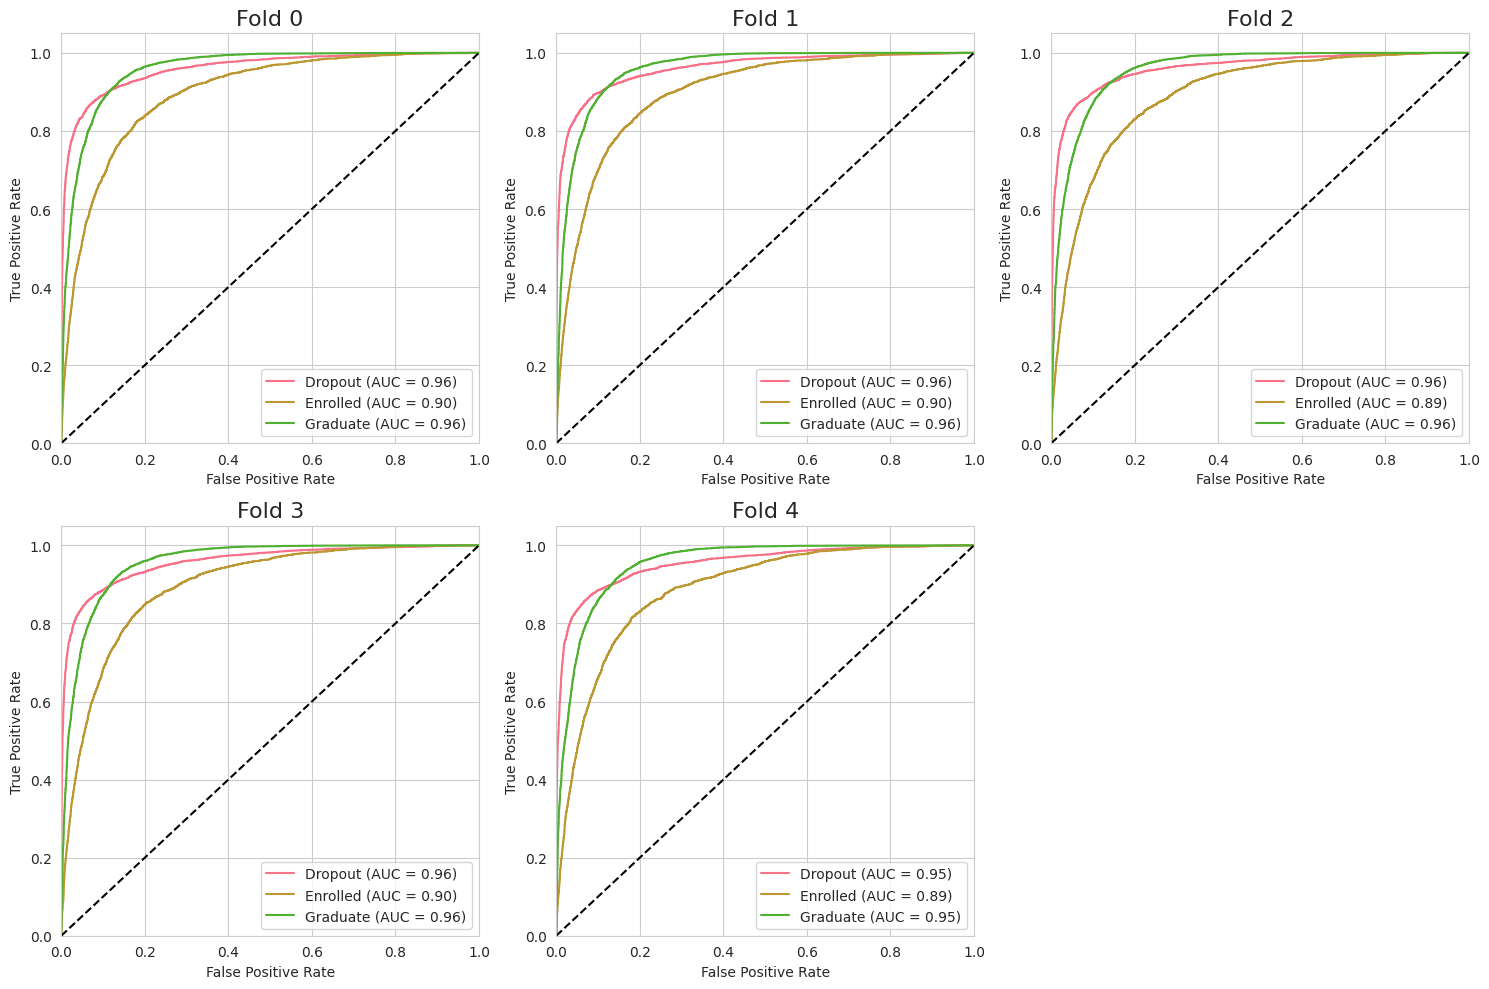

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    pred_probs = histories[f'Fold {fold_idx}']['pred_probs']
    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(pred_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y == i, pred_probs.values[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(pred_probs.shape[1]):
        ax.plot(fpr[i], tpr[i], label=f'{reverse_mappings[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

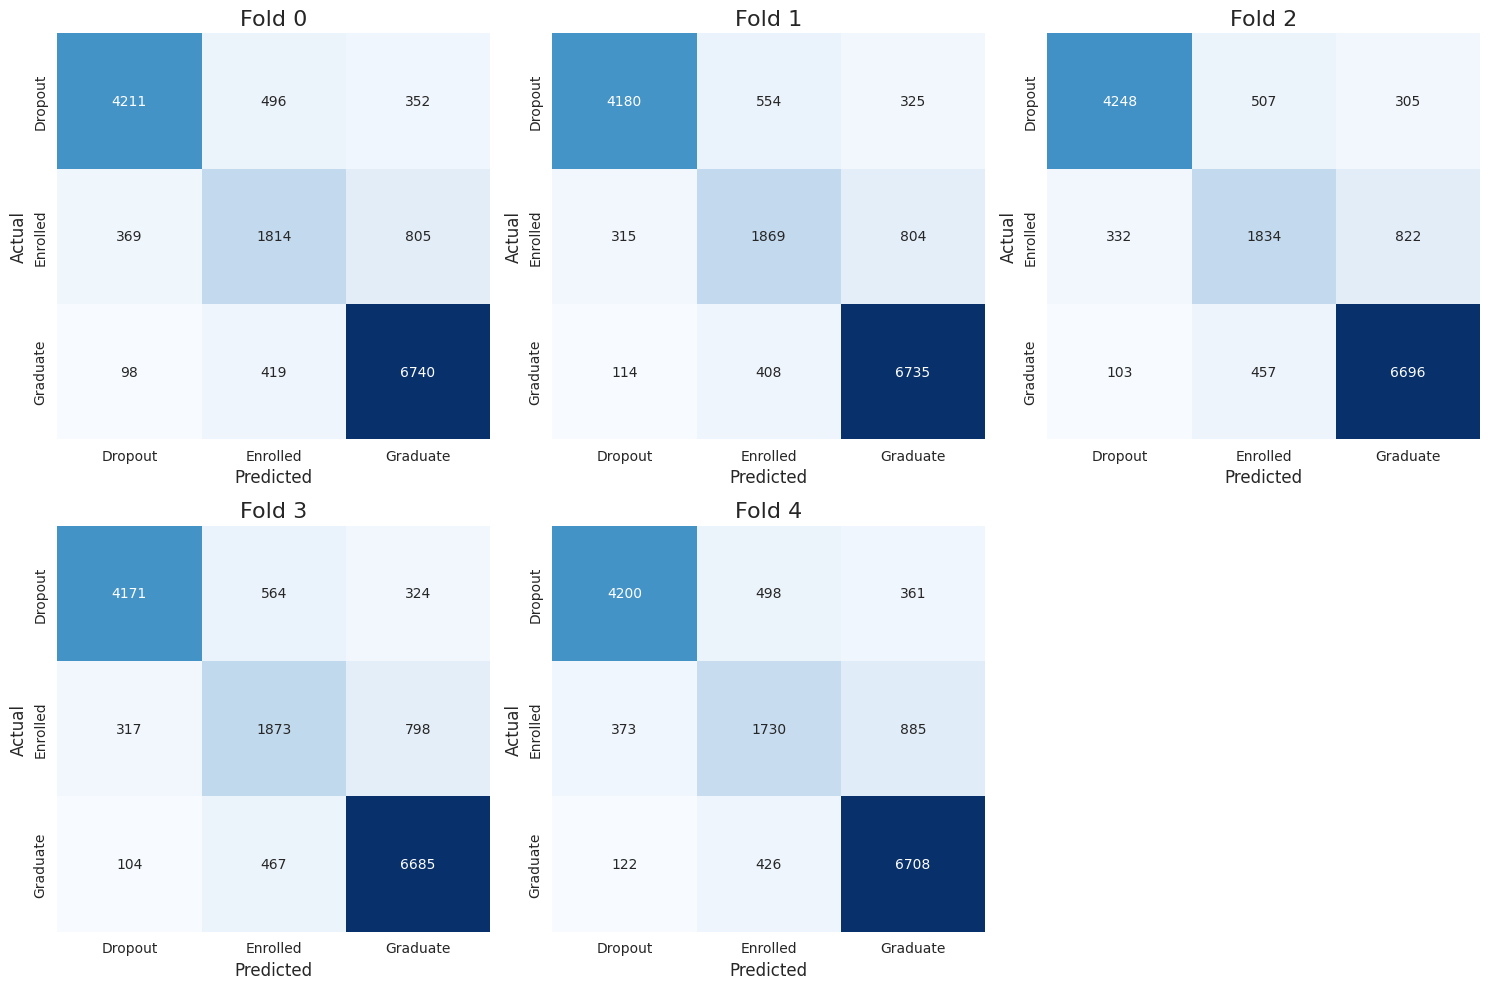

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    cm = confusion_matrix(y, preds)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        ax=ax,
        cmap='Blues',
        cbar=False,
        xticklabels=reverse_mappings.values(),
        yticklabels=reverse_mappings.values()
    )

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Fold {fold_idx}', fontsize=16)

plt.tight_layout()
plt.show()

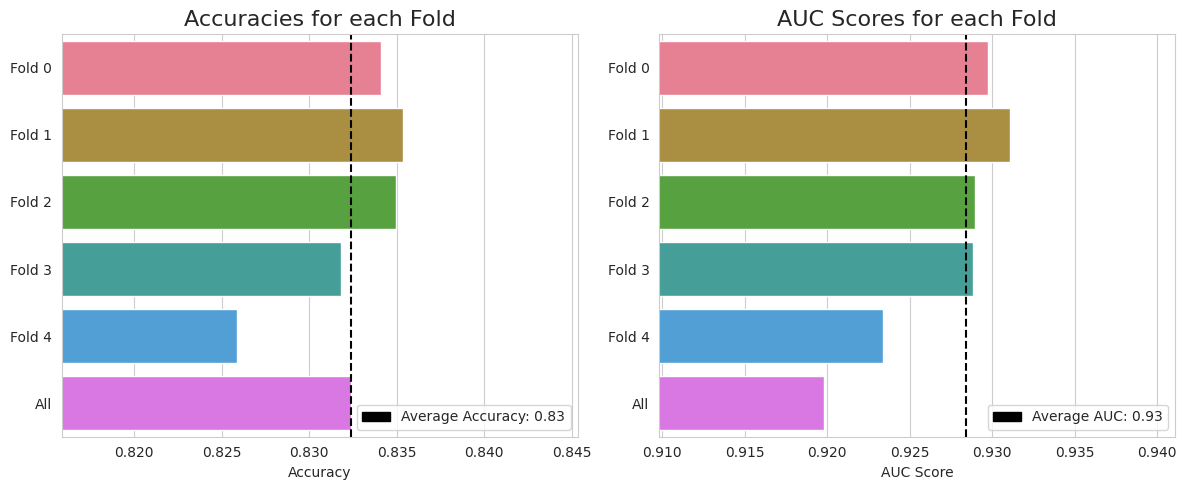

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

accuracies = [histories[f'Fold {i}']['accuracy'] for i in range(N_FOLDS)]
mean_accuracy = np.mean(accuracies)
accuracies = accuracies + [histories['All']['accuracy']]

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=accuracies, ax=axs[0], palette='husl', orient='h')
axs[0].axvline(mean_accuracy, color='black', linestyle='--')
axs[0].set_xlim([min(accuracies) - 0.01, max(accuracies) + 0.01])
axs[0].set_xlabel('Accuracy')
axs[0].set_title('Accuracies for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average Accuracy: {mean_accuracy:.2f}')
axs[0].legend(handles=[blue_patch], loc='best')


auc_scores = [histories[f'Fold {i}']['auc'] for i in range(N_FOLDS)]
mean_auc = np.mean(auc_scores)
auc_scores = auc_scores + [histories['All']['auc']]

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=auc_scores, ax=axs[1], palette='husl', orient='h')
axs[1].axvline(mean_auc, color='black', linestyle='--')
axs[1].set_xlim([min(auc_scores) - 0.01, max(auc_scores) + 0.01])
axs[1].set_xlabel('AUC Score')
axs[1].set_title('AUC Scores for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average AUC: {mean_auc:.2f}')
axs[1].legend(handles=[blue_patch], loc='best')

plt.tight_layout()
plt.show()

# Inference

In [23]:
files = glob.glob('fold_*_test_pred_probs_*.csv')
submissions = [pd.read_csv(f, index_col='id') for f in files]

submission = pd.concat(submissions, axis=1)
submission = submission.groupby(level=0, axis=1).mean()

submission['Target'] = submission.idxmax(axis=1)
submission['id'] = submission.index
submission = submission[['id', 'Target']]

submission.to_csv(f'ag_acc-{mean_accuracy:.6f}_auc-{mean_auc:.6f}.csv', index=False)
submission.head()

,id,Target
id,,
76518,76518,Dropout
76519,76519,Graduate
76520,76520,Graduate
76521,76521,Graduate
76522,76522,Enrolled
